In [2]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv('data\Top100_prediction.csv')


In [4]:
df

,Unnamed: 0,id,store,date,sales,item,store_code,yearweek,sell_price,weekday,event,income
0,103,ACCESORIES_1_108_NYC_1,Greenwich_Village,2011-01-29,4,ACCESORIES_1_108,NYC_1,201105,16.1196,Saturday,0.0,64.4784
1,591,HOME_&_GARDEN_1_027_NYC_1,Greenwich_Village,2011-01-29,4,HOME_&_GARDEN_1_027,NYC_1,201105,6.5500,Saturday,0.0,26.2000
2,615,HOME_&_GARDEN_1_053_NYC_1,Greenwich_Village,2011-01-29,0,HOME_&_GARDEN_1_053,NYC_1,201105,18.7125,Saturday,0.0,0.0000
3,700,HOME_&_GARDEN_1_140_NYC_1,Greenwich_Village,2011-01-29,4,HOME_&_GARDEN_1_140,NYC_1,201105,18.7500,Saturday,0.0,75.0000
4,737,HOME_&_GARDEN_1_177_NYC_1,Greenwich_Village,2011-01-29,0,HOME_&_GARDEN_1_177,NYC_1,201105,9.9625,Saturday,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1739318,58327325,SUPERMARKET_3_783_PHI_3,Queen_Village,2016-04-24,0,SUPERMARKET_3_783,PHI_3,201617,6.5280,Sunday,0.0,0.0000
1739319,58327327,SUPERMARKET_3_785_PHI_3,Queen_Village,2016-04-24,16,SUPERMARKET_3_785,PHI_3,201617,3.6000,Sunday,0.0,57.6000
1739320,58327346,SUPERMARKET_3_804_PHI_3,Queen_Village,2016-04-24,2,SUPERMARKET_3_804,PHI_3,201617,2.2560,Sunday,0.0,4.5120
1739321,58327350,SUPERMARKET_3_808_PHI_3,Queen_Village,2016-04-24,0,SUPERMARKET_3_808,PHI_3,201617,1.1280,Sunday,0.0,0.0000


In [5]:
df_products = df[['item','date','sales','weekday','event']]

In [6]:
df_product = df_products[df_products['item']=='SUPERMARKET_3_586']


In [7]:
df_product

,item,date,sales,weekday,event
45,SUPERMARKET_3_586,2011-01-29,42,Saturday,0.0
105,SUPERMARKET_3_586,2011-01-29,34,Saturday,0.0
167,SUPERMARKET_3_586,2011-01-29,56,Saturday,0.0
224,SUPERMARKET_3_586,2011-01-29,6,Saturday,0.0
285,SUPERMARKET_3_586,2011-01-29,53,Saturday,0.0
...,...,...,...,...,...
1738903,SUPERMARKET_3_586,2016-04-24,75,Sunday,0.0
1739003,SUPERMARKET_3_586,2016-04-24,47,Sunday,0.0
1739103,SUPERMARKET_3_586,2016-04-24,14,Sunday,0.0
1739203,SUPERMARKET_3_586,2016-04-24,24,Sunday,0.0


In [8]:
df_product

,item,date,sales,weekday,event
45,SUPERMARKET_3_586,2011-01-29,42,Saturday,0.0
105,SUPERMARKET_3_586,2011-01-29,34,Saturday,0.0
167,SUPERMARKET_3_586,2011-01-29,56,Saturday,0.0
224,SUPERMARKET_3_586,2011-01-29,6,Saturday,0.0
285,SUPERMARKET_3_586,2011-01-29,53,Saturday,0.0
...,...,...,...,...,...
1738903,SUPERMARKET_3_586,2016-04-24,75,Sunday,0.0
1739003,SUPERMARKET_3_586,2016-04-24,47,Sunday,0.0
1739103,SUPERMARKET_3_586,2016-04-24,14,Sunday,0.0
1739203,SUPERMARKET_3_586,2016-04-24,24,Sunday,0.0


## NO ENTIENDO PARA QUE HACER SIGUIENTE PASO SI TE CARGAS COLUMNA DE SALES

In [13]:
df_product_sin_duplicates = df_product[['date','weekday', 'event']].drop_duplicates()
print(df_product_sin_duplicates.shape)
df_product_sin_duplicates.info()

(1913, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 1913 entries, 45 to 1738403
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     1913 non-null   object 
 1   weekday  1913 non-null   object 
 2   event    1913 non-null   float64
dtypes: float64(1), object(2)
memory usage: 59.8+ KB


In [16]:
ts_predict = df_product.groupby(['date'])['sales'].sum().reset_index() #ts=suma de todas las ventas de todas las tiendas agrupado por día

In [19]:
ts_predict["date"] = pd.to_datetime(ts_predict["date"])

In [17]:
df_product_sin_duplicates["date"] = pd.to_datetime(df_product_sin_duplicates["date"])

In [20]:
ts_predict = ts_predict.merge(df_product_sin_duplicates, on=['date'], how='left')

In [21]:
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)

In [22]:
ts_predict['date'] = pd.to_datetime(ts_predict['date'])

In [23]:
ts_predict.sort_values('date', ascending=True, inplace=True)

In [24]:
ts_predict

,date,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2011-01-29,516,0.0,0,0,1,0,0,0,0
1,2011-01-30,479,0.0,0,0,0,1,0,0,0
2,2011-01-31,328,0.0,0,1,0,0,0,0,0
3,2011-02-01,376,0.0,0,0,0,0,0,1,0
4,2011-02-02,319,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,373,0.0,0,0,0,0,0,0,1
1909,2016-04-21,365,0.0,0,0,0,0,1,0,0
1910,2016-04-22,381,0.0,1,0,0,0,0,0,0
1911,2016-04-23,477,0.0,0,0,1,0,0,0,0


In [25]:
ts_predict.set_index('date', inplace=True)

In [26]:
ts_predict.tail(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2016-04-24,449,0.0,0,0,0,1,0,0,0


Train dates : 2011-01-29 00:00:00 --- 2016-03-25 00:00:00  (n=1883)
Test dates  : 2016-03-26 00:00:00 --- 2016-04-24 00:00:00  (n=30)


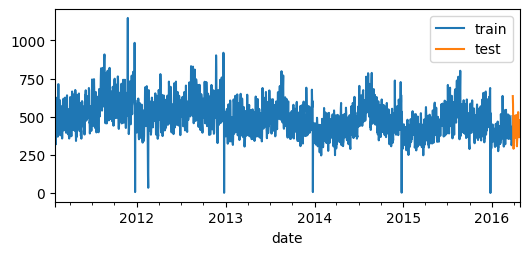

In [27]:
steps = 30
data_train = ts_predict[:-steps]
data_test  = ts_predict[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['sales'].plot(ax=ax, label='train')
data_test['sales'].plot(ax=ax, label='test')
ax.legend();

In [28]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install shap


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 25.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   -------------- ------------------------- 5.8/15.9 MB 25.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/15.9 MB 26.1 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 25.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 1.6/28.1 MB 81.9 MB/s eta 0:00:01
   ---------- ----------------------------- 7.1/28.1 MB 16.2 MB/s eta 0:00:02
   -------------------- ------------------- 14.7/28.1 MB 23.1 MB/s eta 0:00:01
   -------------------------------- ------- 23.1/28.1 MB 27.0 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.1 MB 28.7 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 26.2 MB/s eta 0:00:00
  Atte

  You can safely remove it manually.
  You can safely remove it manually.


In [71]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [77]:
pip uninstall NumPy 

In [30]:
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap
import scipy

C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 3
             )
forecaster.fit(y=data_train['sales'])
forecaster

C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [0, 1882] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-09-11 01:12:30 
Last fit date: 2024-09-11 01:12:31 
Skforecast version: 0.13.0 
Python version: 3.11.9 
Forecaster id: None 

In [37]:
data_train['sales']

date
2011-01-29    516
2011-01-30    479
2011-01-31    328
2011-02-01    376
2011-02-02    319
             ... 
2016-03-21    313
2016-03-22    335
2016-03-23    361
2016-03-24    391
2016-03-25    504
Name: sales, Length: 1883, dtype: int64

In [36]:
# Hyperparameters: grid search
# ==============================================================================
steps = 7
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['sales'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 28.


lags grid:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1187: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\rafas\AppData\Local\Packages\PythonS

KeyError: "None of [Index([3, 4, 5, 6, 7, 8, 9, 3, 4, 5,\n       ...\n       4, 5, 6, 7, 8, 9, 3, 4, 5, 6],\n      dtype='int64', length=942)] are in the [index]"

In [38]:
regressor = RandomForestRegressor(n_estimators=250, max_depth=8, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['sales'])

C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [39]:
predictions = forecaster.predict(steps=30)

C:\Users\rafas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skforecast\utils\utils.py:1187: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [40]:
# Definir el modelo Forecaster
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(),
    lags      = 5  # Esto será optimizado
)

# Grid de hiperparámetros
param_grid = {'lags': [5, 10, 15, 20, 30]}  # Lista de lags que deseas probar

# Búsqueda en el espacio de hiperparámetros con validación cruzada
results = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data_train['sales'],  # Serie temporal de ventas
    param_grid         = param_grid,
    steps              = 7,            # Número de pasos a predecir
    metric             = 'mean_squared_error',
    initial_train_size = int(len(df) * 0.8),  # Tamaño del set de entrenamiento
    refit              = True,
    verbose            = False
)

# Imprimir los mejores resultados
print(results)

Number of models compared: 5.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Invalid parameter 'lags' for estimator RandomForestRegressor(). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [28]:
predictions = forecaster.predict(steps=30)
predictions.head(5)

NameError: name 'forecaster' is not defined

In [29]:
predictions = predictions.reindex(data_test.index)

NameError: name 'predictions' is not defined

In [30]:
predictions

NameError: name 'predictions' is not defined

In [31]:
data_test['predict'] = predictions

NameError: name 'predictions' is not defined

In [32]:
data_test.head()

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2016-03-26,635,0.0,0,0,1,0,0,0,0
2016-03-27,579,1.0,0,0,0,1,0,0,0
2016-03-28,339,0.0,0,1,0,0,0,0,0
2016-03-29,290,0.0,0,0,0,0,0,1,0
2016-03-30,300,0.0,0,0,0,0,0,0,1


In [33]:
ts_predict.reset_index(inplace=True)

NameError: name 'predictions' is not defined

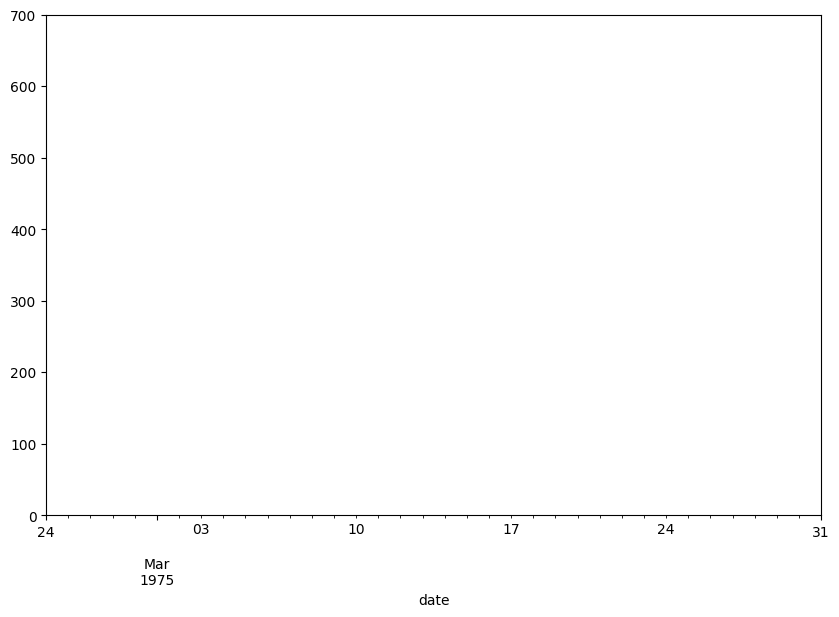

In [34]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'].plot(ax=ax, label='train')
data_test['sales'].plot(ax=ax, label='test')
ax.set_xlim(1880,1915)
ax.set_ylim(0,700)
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [128]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 24276.528910000005


In [41]:
data_test['sales']

date
2016-03-26    635
2016-03-27    579
2016-03-28    339
2016-03-29    290
2016-03-30    300
2016-03-31    332
2016-04-01    405
2016-04-02    485
2016-04-03    506
2016-04-04    362
2016-04-05    411
2016-04-06    366
2016-04-07    427
2016-04-08    409
2016-04-09    511
2016-04-10    502
2016-04-11    381
2016-04-12    306
2016-04-13    343
2016-04-14    369
2016-04-15    396
2016-04-16    481
2016-04-17    530
2016-04-18    391
2016-04-19    434
2016-04-20    373
2016-04-21    365
2016-04-22    381
2016-04-23    477
2016-04-24    449
Name: sales, dtype: int64

In [150]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 2619.367500940703


## Con exógenas

In [168]:
data_test.columns

Index(['level_0', 'index', 'date', 'sales', 'event', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')

In [35]:
ts_predict.head(1)

,date,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2011-01-29,516,0.0,0,0,1,0,0,0,0


In [36]:
# # Definir el punto de división (80% de los datos para entrenamiento)
# train_size = -30

# # Dividir la serie objetivo en train y test
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # Dividir las variables exógenas en train y test
# exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [37]:
y = ts_predict['sales']
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1913 entries, 0 to 1912
Series name: sales
Non-Null Count  Dtype
--------------  -----
1913 non-null   int64
dtypes: int64(1)
memory usage: 15.1 KB


In [38]:
exog = ts_predict[['event', 'weekday_Friday', 'weekday_Monday','weekday_Saturday', 'weekday_Sunday','weekday_Thursday','weekday_Tuesday','weekday_Wednesday']]
exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event              1913 non-null   float64
 1   weekday_Friday     1913 non-null   int64  
 2   weekday_Monday     1913 non-null   int64  
 3   weekday_Saturday   1913 non-null   int64  
 4   weekday_Sunday     1913 non-null   int64  
 5   weekday_Thursday   1913 non-null   int64  
 6   weekday_Tuesday    1913 non-null   int64  
 7   weekday_Wednesday  1913 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 119.7 KB


In [39]:
y_train, y_test= y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [40]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 30 entries, 1883 to 1912
Series name: sales
Non-Null Count  Dtype
--------------  -----
30 non-null     int64
dtypes: int64(1)
memory usage: 372.0 bytes


In [41]:
exog_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1883 to 1912
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event              30 non-null     float64
 1   weekday_Friday     30 non-null     int64  
 2   weekday_Monday     30 non-null     int64  
 3   weekday_Saturday   30 non-null     int64  
 4   weekday_Sunday     30 non-null     int64  
 5   weekday_Thursday   30 non-null     int64  
 6   weekday_Tuesday    30 non-null     int64  
 7   weekday_Wednesday  30 non-null     int64  
dtypes: float64(1), int64(7)
memory usage: 2.0 KB


In [42]:
# Asegúrate de que el índice sea DatetimeIndex
if not isinstance(y_train.index, pd.DatetimeIndex):
    y_train.index = pd.to_datetime(y_train.index)

if not isinstance(exog_train.index, pd.DatetimeIndex):
    exog_train.index = pd.to_datetime(exog_train.index)

if not isinstance(y_test.index, pd.DatetimeIndex):
    y_test.index = pd.to_datetime(y_test.index)

if not isinstance(exog_test.index, pd.DatetimeIndex):
    exog_test.index = pd.to_datetime(exog_test.index)

In [43]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=7  # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)
forecaster

ModuleNotFoundError: No module named 'skforecast'

In [44]:
predictions.index()

NameError: name 'predictions' is not defined

In [45]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

# Evaluar el modelo comparando las predicciones con los valores reales
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

NameError: name 'forecaster' is not defined